In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestRegressor
import datetime
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
import shap
from tensorflow import keras
import tensorflow as tf

In [3]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
train = catalog.load("train_contract_value")
cv = catalog.load("cv_contract_value")
test = catalog.load("test_contract_value")

[08/14/22 22:05:12] INFO     Loading data from 'train_contract_value' (ParquetDataSet)...       ]8;id=457037;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=859620;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[08/14/22 22:05:17] INFO     Loading data from 'cv_contract_value' (ParquetDataSet)...          ]8;id=626370;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=392785;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[08/14/22 22:05:18] INFO     Loading data from 'test_contract_value' (ParquetDataSet)...        ]8;id=496170;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=228393;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

In [5]:
y_train = train["log_valor_del_contrato"].values
y_cv = cv["log_valor_del_contrato"].values
y_test = test["log_valor_del_contrato"].values

<IPython.core.display.Javascript object>

In [6]:
train.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)
cv.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)
test.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)), 1)
    max_depth = np.random.choice([2, 5, 7, 10, 15, 20])
    min_samples_leaf = np.random.randint(1, 100)
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
    }

<IPython.core.display.Javascript object>

In [8]:
xn_cv = 15
score = np.inf
final_params = None
for i in range(n_cv):
    if i % 2 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestRegressor(**params)
    model.fit(train, y_train)
    pred = model.predict(cv)
    cv_score = mean_squared_error(y_cv, pred) ** 0.5
    if cv_score < score:
        score = cv_score
        final_params = params
    print(f"Iteration {i+1} - RMSE :{cv_score}")

Iteration 1 - 15: CV - 16:12:14
Iteration 1 - RMSE :0.9746217383885054
Iteration 2 - RMSE :0.9416737146608866
Iteration 3 - 15: CV - 16:48:45
Iteration 3 - RMSE :1.3284620083348861
Iteration 4 - RMSE :1.1689281964437488
Iteration 5 - 15: CV - 16:50:31
Iteration 5 - RMSE :0.9709298880135664
Iteration 6 - RMSE :0.943415727446579
Iteration 7 - 15: CV - 16:55:28
Iteration 7 - RMSE :1.276198734914523
Iteration 8 - RMSE :1.1725846201431211
Iteration 9 - 15: CV - 16:56:01
Iteration 9 - RMSE :0.9478364571604433
Iteration 10 - RMSE :0.9475336320378565
Iteration 11 - 15: CV - 17:20:34
Iteration 11 - RMSE :0.9665313830287949
Iteration 12 - RMSE :1.0056847393908643
Iteration 13 - 15: CV - 17:24:26
Iteration 13 - RMSE :0.9833955531999348
Iteration 14 - RMSE :0.940890443906045
Iteration 15 - 15: CV - 18:14:48
Iteration 15 - RMSE :0.9492668091049051


<IPython.core.display.Javascript object>

In [12]:
# final_params = {
#    "n_estimators": 78,
#    "max_depth": 20,
#    "min_samples_leaf": 77,
#    "max_features": 0.8530949098629828,
# }

<IPython.core.display.Javascript object>

In [13]:
model = RandomForestRegressor(**final_params)
model.fit(train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.8530949098629828,
                      min_samples_leaf=77, n_estimators=78)

<IPython.core.display.Javascript object>

In [14]:
pred_test = model.predict(test)

<IPython.core.display.Javascript object>

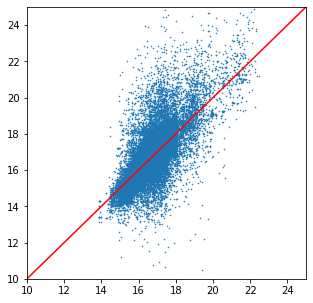

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots()
ax.scatter(x=pred_test, y=y_test, s=0.3)
ax.plot([10, 25], [10, 25], c="red")
ax.set_xlim(10, 25)
ax.set_ylim(10, 25)
fig.set_size_inches(5, 5)

(-10.0, 10.0)

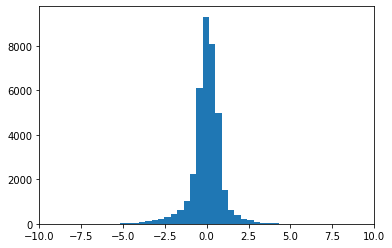

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots()
ax.hist(pred_test - y_test, bins=80)
ax.set_xlim(-10, 10)

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test, y_test)

<IPython.core.display.Javascript object>

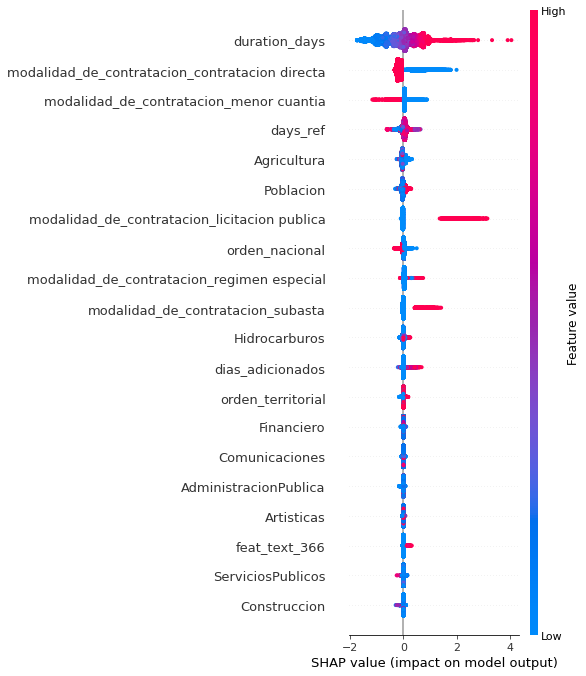

<IPython.core.display.Javascript object>

In [41]:
shap.summary_plot(shap_values, test)

## Deep neural network

In [23]:
inputs = keras.layers.Input([len(train.columns)], dtype=tf.float32)
x = keras.layers.Dense(300, activation="relu")(inputs)
x = keras.layers.Dropout(0.6)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(150, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(70, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [24]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 427)]             0         
                                                                 
 dense_18 (Dense)            (None, 300)               128400    
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 150)               45150     
                                                                 
 dropout_13 (Dropout)        (None, 150)               0         
                                                           

<IPython.core.display.Javascript object>

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

<IPython.core.display.Javascript object>

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "../../data/06_models/dnn_2", save_best_only=True, monitor="val_loss", verbose=False
)

<IPython.core.display.Javascript object>

In [31]:
fit_history_3 = model.fit(
    x=train.values,
    y=y_train,
    validation_data=(cv.values, y_cv),
    epochs=800,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=1000000,
)

Epoch 1/800
1/1 [==============================] - 7s 7s/step - loss: 16.9366 - root_mean_squared_error: 4.1154 - val_loss: 9.5897 - val_root_mean_squared_error: 3.0967
Epoch 2/800
1/1 [==============================] - 3s 3s/step - loss: 16.9619 - root_mean_squared_error: 4.1185 - val_loss: 9.6123 - val_root_mean_squared_error: 3.1004
Epoch 3/800
1/1 [==============================] - 3s 3s/step - loss: 16.8903 - root_mean_squared_error: 4.1098 - val_loss: 9.6279 - val_root_mean_squared_error: 3.1029
Epoch 4/800
1/1 [==============================] - 3s 3s/step - loss: 16.8244 - root_mean_squared_error: 4.1018 - val_loss: 9.6387 - val_root_mean_squared_error: 3.1046
Epoch 5/800
1/1 [==============================] - 3s 3s/step - loss: 16.7886 - root_mean_squared_error: 4.0974 - val_loss: 9.6489 - val_root_mean_squared_error: 3.1063
Epoch 6/800
1/1 [==============================] - 3s 3s/step - loss: 16.7328 - root_mean_squared_error: 4.0906 - val_loss: 9.6687 - val_root_mean_squared_

1/1 [==============================] - 3s 3s/step - loss: 14.6828 - root_mean_squared_error: 3.8318 - val_loss: 10.3879 - val_root_mean_squared_error: 3.2230
Epoch 50/800
1/1 [==============================] - 3s 3s/step - loss: 14.6179 - root_mean_squared_error: 3.8233 - val_loss: 10.4125 - val_root_mean_squared_error: 3.2268
Epoch 51/800
1/1 [==============================] - 3s 3s/step - loss: 14.5598 - root_mean_squared_error: 3.8157 - val_loss: 10.4450 - val_root_mean_squared_error: 3.2319


<IPython.core.display.Javascript object>

[<matplotlib.lines.Line2D object at 0x2db593dc0>]

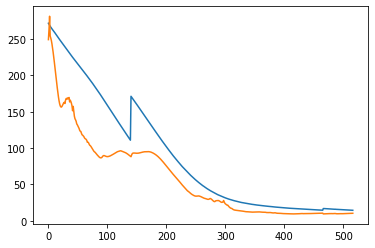

<IPython.core.display.Javascript object>

In [32]:
plt.plot(
    fit_history.history["loss"]
    + fit_history_2.history["loss"]
    + fit_history_3.history["loss"]
)
plt.plot(
    fit_history.history["val_loss"]
    + fit_history_2.history["val_loss"]
    + fit_history_3.history["val_loss"]
)

[<matplotlib.lines.Line2D object at 0x8eaea47c0>]

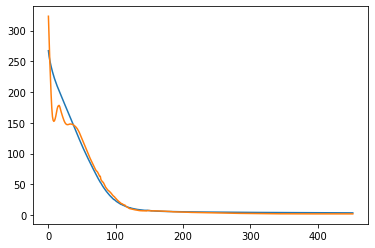

<IPython.core.display.Javascript object>

In [13]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

(0.0, 20.0)

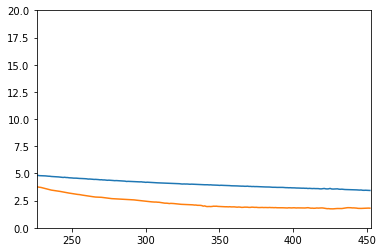

<IPython.core.display.Javascript object>

In [14]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
ax = plt.gca()
ax.set_xlim(int(len(fit_history.history['loss'])/2),len(fit_history.history['loss']))
ax.set_ylim(0,20)

[<matplotlib.lines.Line2D object at 0x8f3dec490>]

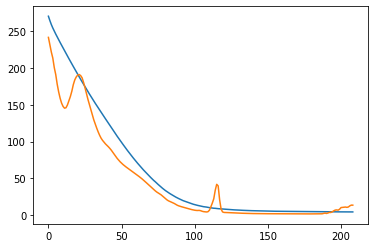

<IPython.core.display.Javascript object>

In [13]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

(0.0, 20.0)

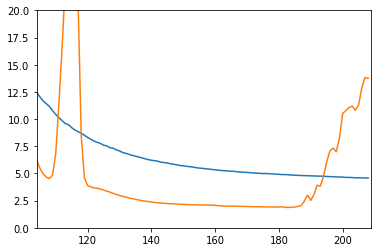

<IPython.core.display.Javascript object>

In [14]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
ax = plt.gca()
ax.set_xlim(int(len(fit_history.history['loss'])/2),len(fit_history.history['loss']))
ax.set_ylim(0,20)

[<matplotlib.lines.Line2D object at 0x8ed784b50>]

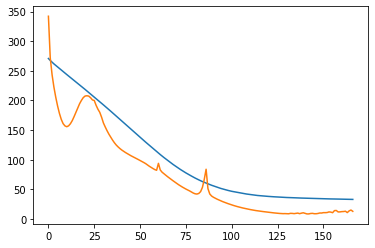

<IPython.core.display.Javascript object>

In [13]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])